In [1]:
import os
import torch
import mlflow
os.environ["KERAS_BACKEND"] = "torch"
import keras
import pandas as pd
import numpy as np

import plotly.express as px

from prediction import Predictor
from prediction.predictor import build_model_benchmark_df

import prediction.plot as plot
import prediction.transform as trf
from typing import Optional
import temporal_fusion_transformers as tft

import mlops.mlflow_utils as mlflow_utils


os.environ["MLFLOW_TRACKING_URI"] = "https://mlflow-server-med-jupyter-central-dev.apps.dev.ocp.bisinfo.org"



In [2]:
parent_id = mlflow_utils.get_most_recent_parent_run_id()
runs = mlflow_utils.get_tft_child_run_df(parent_id)
runs.head()

run_id  experiment_id    status  \
0  ce64a1d4fc9944589af6bc28b806255e              4  FINISHED   
1  ea89d48017004d1ca55eec03e4f21c64              4  FINISHED   
2  9d72f33664874753955206b1f69db1ab              4  FINISHED   
3  069d975898384bef9aed6a81cf8a836f              4  FINISHED   
4  780f87ea9e2d4ff6b47abd9b3fc2aa5c              4  FINISHED   

                                        artifact_uri           start_time  \
0  mlflow-artifacts:/4/ce64a1d4fc9944589af6bc28b8...  1709716288779000000   
1  mlflow-artifacts:/4/ea89d48017004d1ca55eec03e4...  1709709152409000000   
2  mlflow-artifacts:/4/9d72f33664874753955206b1f6...  1709702397605000000   
3  mlflow-artifacts:/4/069d975898384bef9aed6a81cf...  1709688049346000000   
4  mlflow-artifacts:/4/780f87ea9e2d4ff6b47abd9b3f...  1709676891632000000   

              end_time  metrics.rmse_yoy_CH_4_months_ahead  \
0  1709722485242000000                            0.396118   
1  1709716288696000000                            0.463462   
2  1709709152319000000                            0.382134   
3  1709702397521000000                            0.497438   
4  1709688049260000000                            0.405748   

   metrics.rmse_yoy_GB_7_months_ahead  metrics.rmse_yoy_US_12_months_ahead  \
0                            0.395619                             0.423140   
1                            0.626591                             1.077894   
2                            0.359696                             0.349896   
3                            0.821945                             0.915278   
4                            0.442687                             0.483668   

   metrics.rmse_yoy_CH_3_months_ahead  ...  params.start_date_train  \
0                            0.346115  ...               1980-01-01   
1                            0.378757  ...               1980-01-01   
2                            0.326245  ...               1980-01-01   
3                            0.401676  ...               1980-01-01   
4                            0.338656  ...               1980-01-01   

   params.optimizer_epsilon  params.min_context  \
0              1.000000e-07                  90   
1              1.000000e-07                  90   
2              1.000000e-07                  90   
3              1.000000e-07                  90   
4              1.000000e-07                  90   

   params.optimizer_ema_momentum  tags.mlflow.runName  \
0                           0.99     defiant-flea-334   
1                           0.99    defiant-steed-113   
2                           0.99      clumsy-lark-190   
3                           0.99       aged-chimp-680   
4                           0.99    secretive-mouse-5   

                       tags.mlflow.log-model.history  tags.mlflow.user  \
0  [{"run_id": "ce64a1d4fc9944589af6bc28b806255e"...        1000900000   
1  [{"run_id": "ea89d48017004d1ca55eec03e4f21c64"...        1000900000   
2  [{"run_id": "9d72f33664874753955206b1f69db1ab"...        1000900000   
3  [{"run_id": "069d975898384bef9aed6a81cf8a836f"...        1000900000   
4  [{"run_id": "780f87ea9e2d4ff6b47abd9b3fc2aa5c"...        1000900000   

   tags.mlflow.source.type  tags.mlflow.source.name  \
0                    LOCAL                 train.py   
1                    LOCAL                 train.py   
2                    LOCAL                 train.py   
3                    LOCAL                 train.py   
4                    LOCAL                 train.py   

            tags.mlflow.parentRunId  
0  705e524ecdcf49b5a0dd190441030f00  
1  705e524ecdcf49b5a0dd190441030f00  
2  705e524ecdcf49b5a0dd190441030f00  
3  705e524ecdcf49b5a0dd190441030f00  
4  705e524ecdcf49b5a0dd190441030f00  

[5 rows x 140 columns]

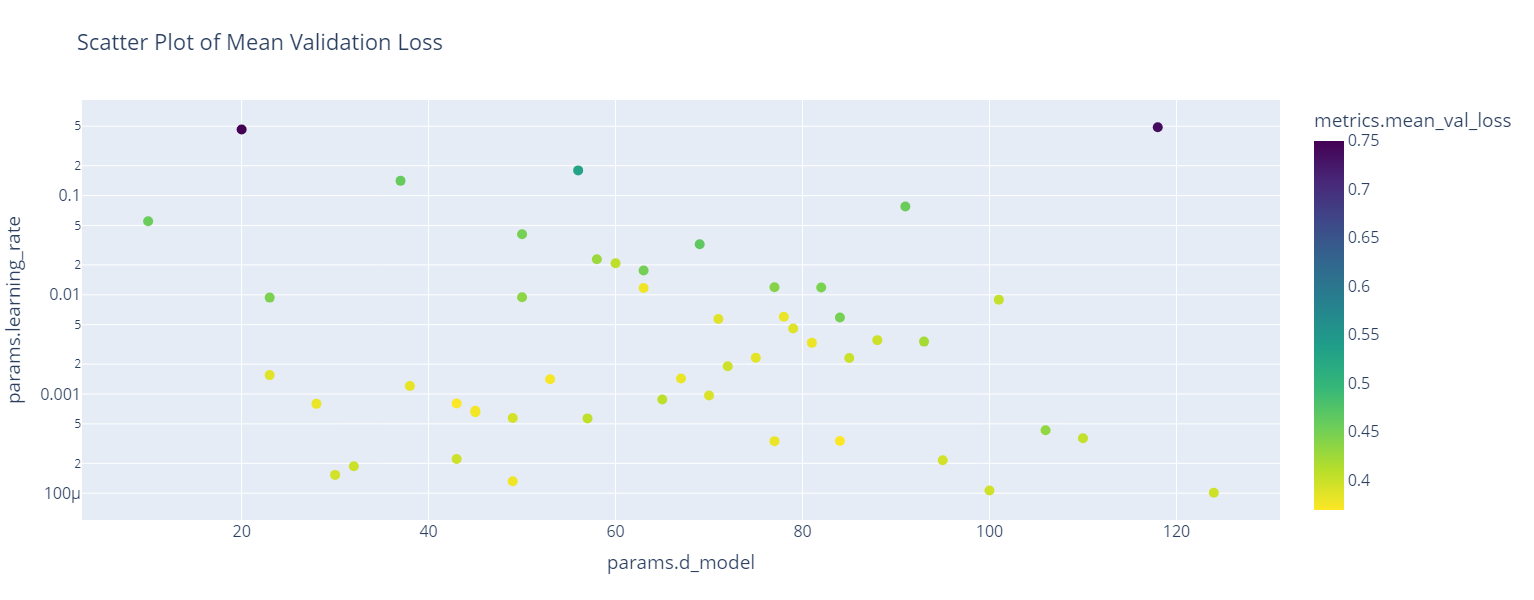

In [3]:
fig = px.scatter(
    runs, 
    x="params.d_model", 
    y="params.learning_rate", 
    color="metrics.mean_val_loss", 
    log_y=True, 
    title="Scatter Plot of Mean Validation Loss", 
    color_continuous_scale=px.colors.sequential.Viridis_r,
    width=1200,
    height=600,
    hover_data=["run_id"],
)
fig.update_traces(marker_size=10)
fig.update_layout(
    font=dict(
        size=16,  # Set the font size here
    )
)


In [4]:
runs = runs[runs["params.learning_rate"] < 0.05]

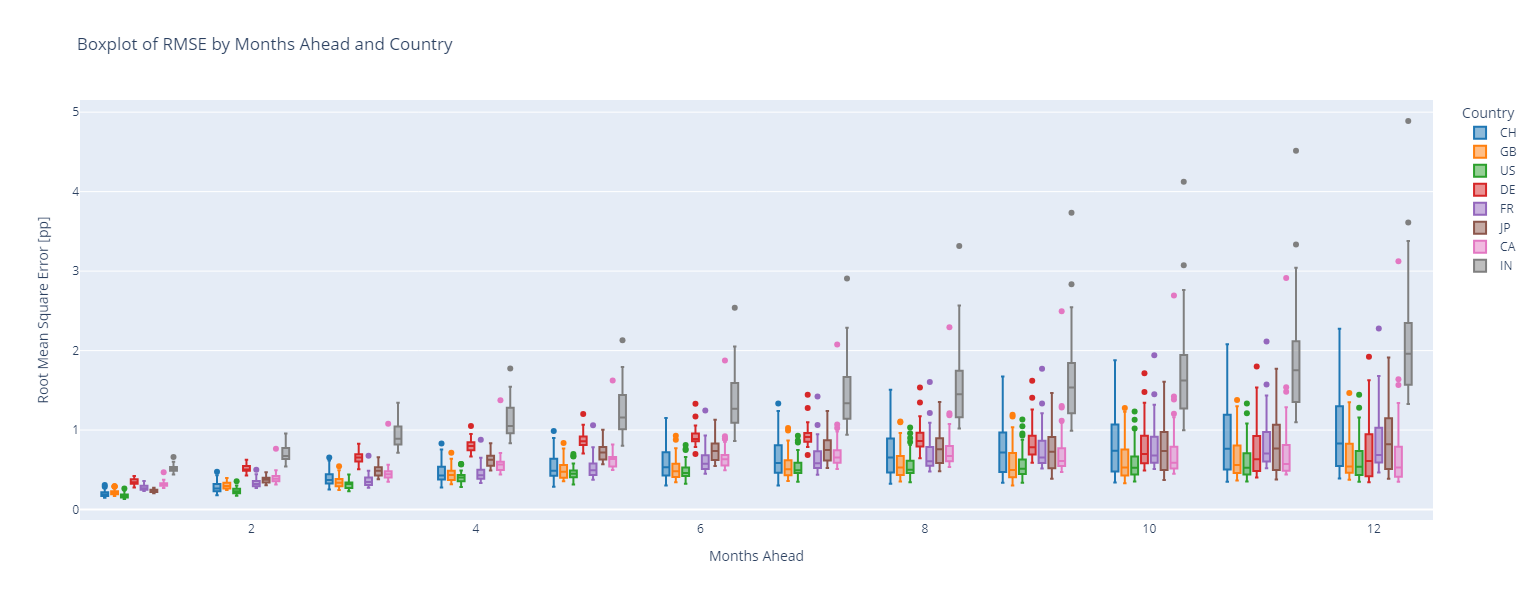

In [5]:
long_df = trf.transform_rmse_box_plot(runs)


# Create a boxplot
fig = px.box(long_df, x='Months Ahead', y='RMSE', color='Country', 
             color_discrete_sequence=px.colors.qualitative.D3,
             labels={'RMSE': 'Root Mean Square Error [pp]'},  # Optional: customizing axis labels
             title='Boxplot of RMSE by Months Ahead and Country',
             width=1200,
             height=600
             
            
)  # Optional: adding a title
    

# Show the plot
fig.show()

In [6]:
start_date = "2000-01-01"
end_date = "2023-12-01"
model = mlflow_utils.get_best_model(parent_id, metric="metrics.mean_val_loss")
p = Predictor(model, start_date, end_date)

/opt/app-root/src/jupyter_workspace/share/nowcasting/NowcastML/nowcastenv/lib64/python3.9/site-packages/keras/src/saving/saving_lib.py:388: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 332 variables. 

100%|██████████| 1/1 [00:00<00:00, 134.07it/s]
/opt/app-root/src/jupyter_workspace/share/nowcasting/NowcastML/nowcastenv/lib64/python3.9/site-packages/keras/src/saving/saving_lib.py:388: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 332 variables. 



In [7]:
df = build_model_benchmark_df(p, parent_id, start_date, end_date, tft.countries, [1, 6, 12])

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 608ms/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 607ms/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 622ms/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 605ms/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 620ms/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 615ms/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 608ms/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 602ms/step


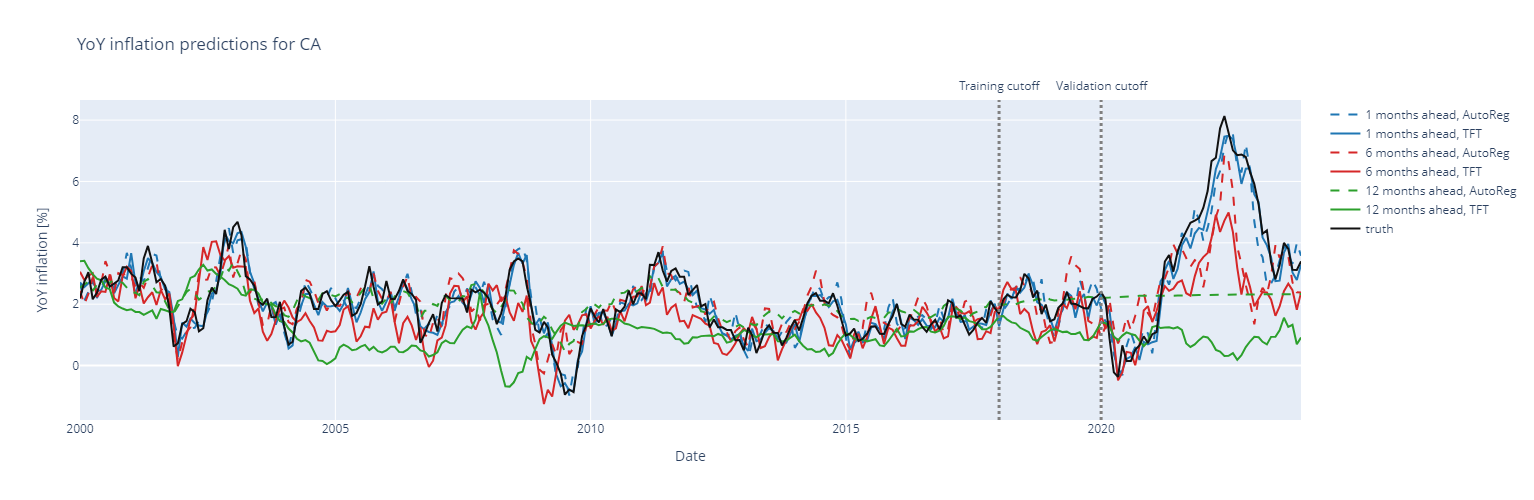

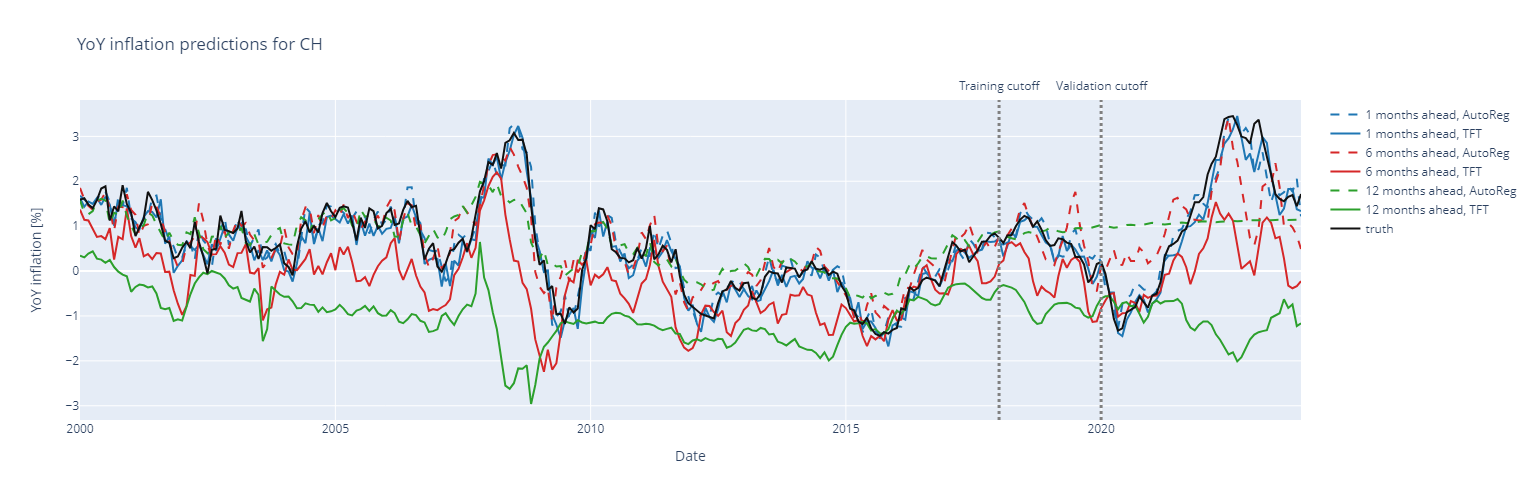

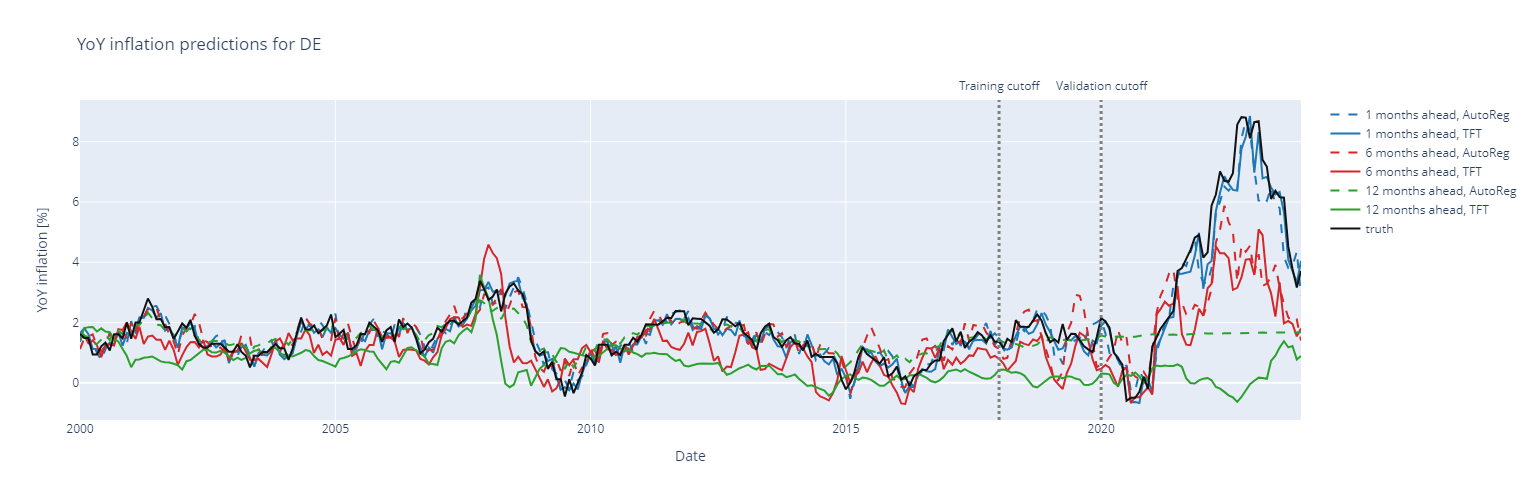

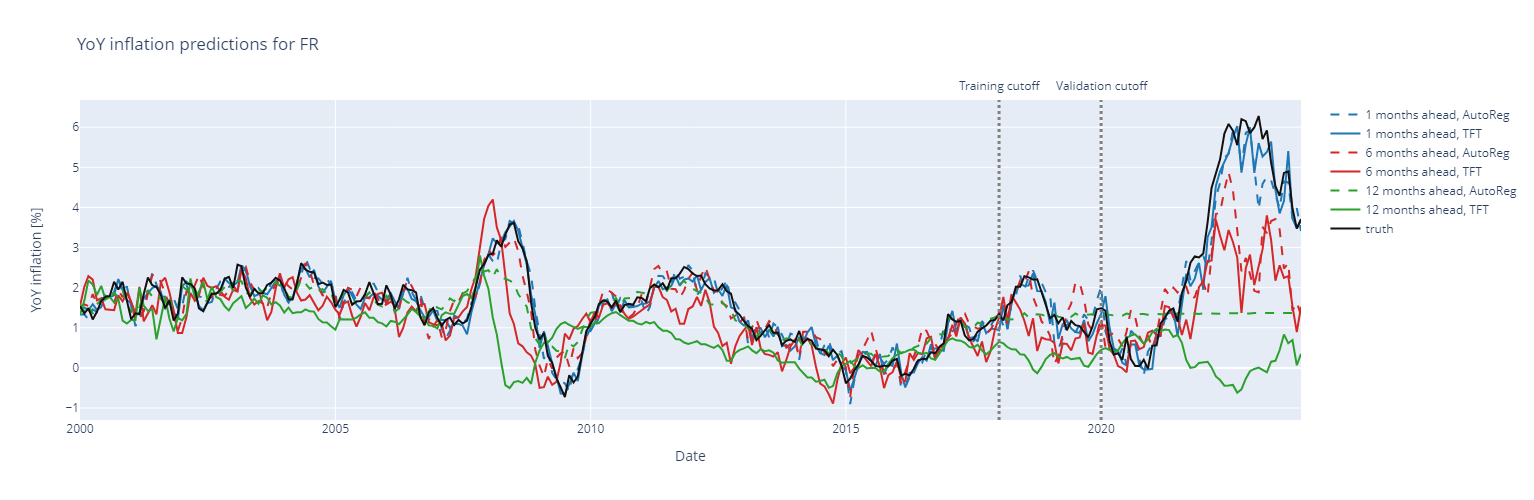

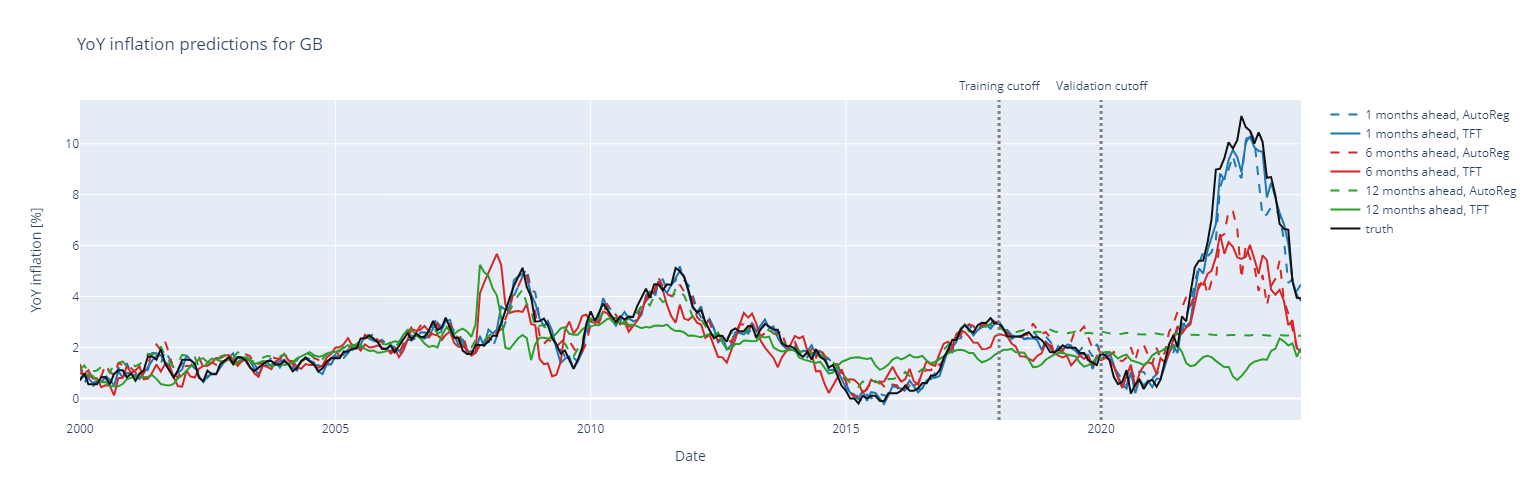

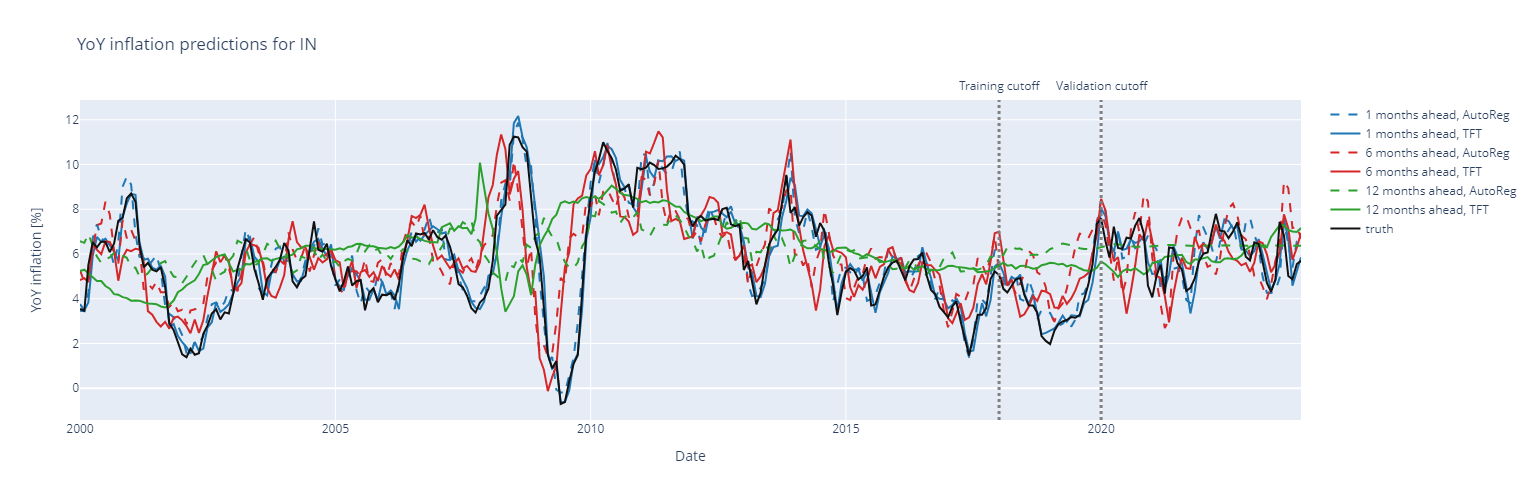

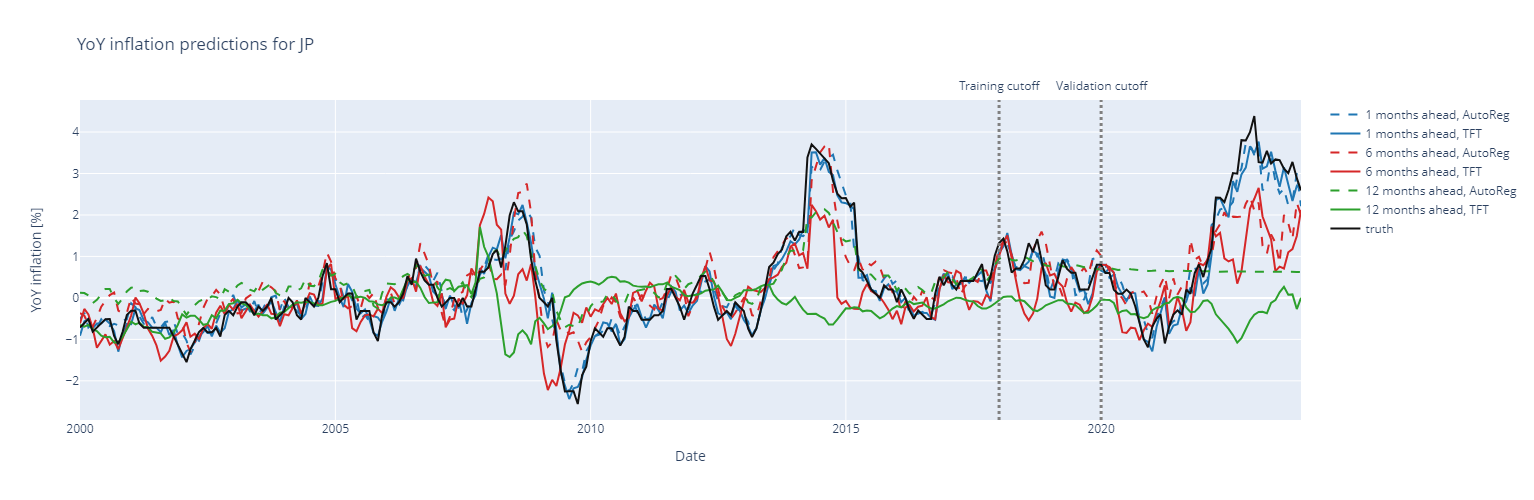

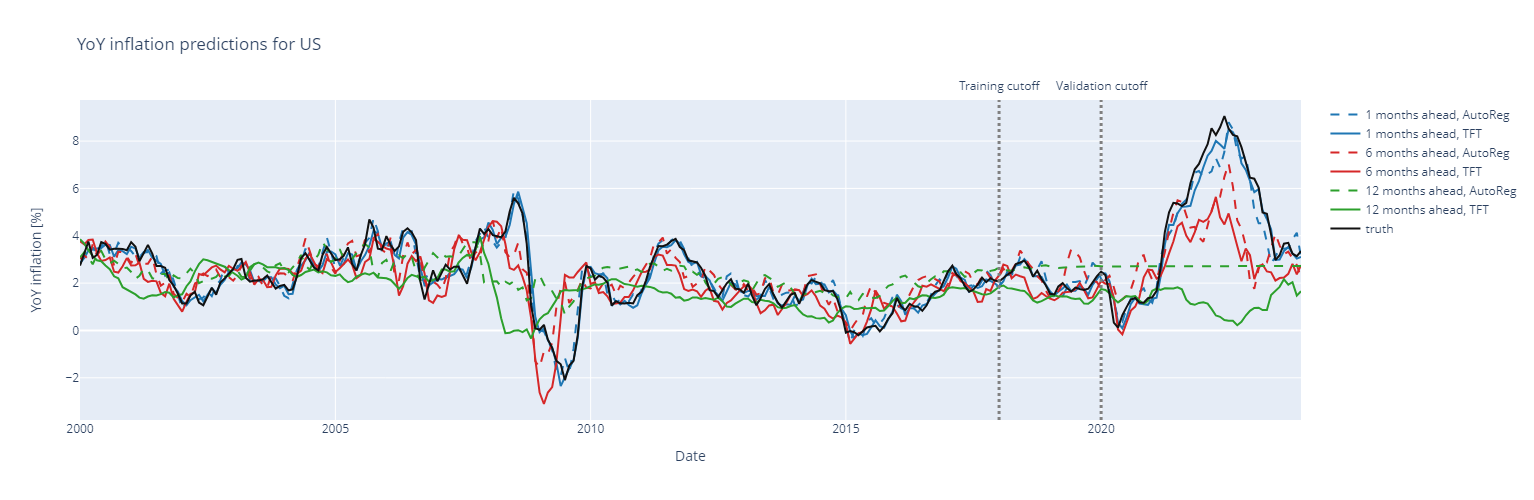

In [8]:
for country in tft.countries:
    fig = plot.plot_prediction_benchmark(df, country, [1, 6, 12])
    fig.show()